# Setup

In [15]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.dates as dates

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D
import cmocean

# Timing Processes
import time

# make sure the figures plot inline rather than at the end
%matplotlib inline

## <font color='orange'>Parameters</font> 

In [4]:
# these are for grouping into the IOD years since the effects are 
# not confined to a single year. You chose this to have an even 
# number of months around the IOD peak..but now you left it in
# line with the SLA plots that start in 06 and end in 05
IODyear_begin = '-06-01' # month-day of IOD year
IODyear_end = '-05-31' # month-day of year AFTER IOD year

## <font color='orange'>Functions</font> 

In [5]:
def add_land(ax,bounds):
    res = '50m'
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    land = cfeature.NaturalEarthFeature('physical', 'land', res,
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
    ax.add_feature(land,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution=res,zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())

def IOD_year_group(invar,begin,end,IODyears):
    data= []
    for ii,year in enumerate(IODyears):
        start_time = str(year) + begin
        end_time = str(year+1) + end
        time_slice = slice(start_time, end_time)
#         print(time_slice)
        data.append(invar.sel(time=time_slice))
        
    # add all the data together
    data = xr.concat(data, dim='time')
    # take the mean for each month of all the years
    data = data.groupby('time.month').mean(dim='time')
    #start in June instead of 01
    data = data.roll(month=-5,roll_coords = False)
        
    return data

def plot_annual_cycle(invar,cmap,cmin,cmax,clabel,levels,stitle):
    
    fig = plt.figure(figsize=(20, 20))
    plt.rcParams.update({'font.size': 20})
    
    months = ['Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']

    for mm in range(invar.shape[0]):
        ax = fig.add_subplot(4,3,mm+1, projection=ccrs.PlateCarree())
        cf = ax.contourf(lon,lat,invar[mm,:,:],levels = levels,cmap=cmap, extend="both")
        add_land(ax,[40,100,-5,30])
        plt.title(months[mm])
        
        if (mm == 0) | (mm == 3) | (mm == 6) | (mm == 9):
            plt.ylabel('Latitude')
            
        if (mm == 9) | (mm == 10) | (mm == 11):
            plt.xlabel('Longitude')
    
    plt.suptitle(stitle)
    cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
    cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
    cbar.set_label(clabel)
    
def plot_coastal_hovmueller(IODphases,cmap,cmin,cmax,clabel):
    # create list of integer years
    titles = ['Annual Cycle','Positive Phase','Negative Phase', 'Neutral Phase']
    plt.rcParams.update({'font.size': 20})

    fig = plt.figure(figsize=(30, 10))
    for ii,phase in enumerate(IODphases):

        # Get times and make array of datetime objects
        vtimes = phase.month

        data = np.zeros([vtimes.shape[0],ds_CL.sta_loninds.shape[0]])*np.nan
    #     print(data.shape)
        for jj in range(ds_CL.sta_loninds.shape[0]):
            data[:,jj] = phase[:,ds_CL.sta_latinds[jj],ds_CL.sta_loninds[jj]]

        # colorbar limits
        levels = np.linspace(cmin, cmax, 8)

        # Specify longitude values for chosen domain
        sta = np.arange(len(ds_CL.sta_loninds))

        ax = fig.add_subplot(1,4,ii+1)

        # Plot of chosen variable averaged over latitude and slightly smoothed
        cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=cmap, extend="both")
        for loc in ds_CL.loc_list:
            plt.axvline(x=loc,color = 'k',linestyle = ':')

        plt.xlabel('Station')
        if ii == 0:
            plt.ylabel('Month')

        plt.title(titles[ii])
        ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
        ax.set_xticks(ds_CL.loc_list)
        ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
        ax.set_yticks(list(np.arange(1,13)))
        cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

    cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
    cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
    cbar.set_label(clabel)

## <font color='orange'>Read Data</font> 

In [7]:
# get data from tigress
path = '../data/SST/'
infn = 'sst_processed.nc'
ds_SST = xr.open_dataset(path + infn)

# Subset ------------------------------------------------#
# Create slice variables to subset domain before finding means
lat_slice = slice(-20, 30) # bounds inclusive
lon_slice = slice(40, 100) # bounds inclusive

# Get data, selecting lat/lon slice
mon_ssta = ds_SST['mon_ssta'].sel(lat=lat_slice,lon=lon_slice)
mon_ssta_mon_anom = ds_SST['mon_ssta_mon_anom'].sel(lat=lat_slice,lon=lon_slice)
ssta_mon_clim = ds_SST['ssta_mon_clim'].sel(lat=lat_slice,lon=lon_slice)
lat = mon_ssta_mon_anom.lat.values
lon = mon_ssta_mon_anom.lon.values

# # load coastlines
# ds_CL= xr.open_dataset('../data/CHL/CHL-1-degree-coastlines.nc')

## <font color='orange'>Group Into IOD Phases</font> 

In [8]:
# load DMI data
ds_DMI= xr.open_dataset('../data/DMI/dmi_processed.nc')
ds_DMI

posIODyears = list(np.array(ds_DMI.pos_IOD_years[ds_DMI.pos_IOD_years >= 1994]))
# posIODyears = [1997,2019]
negIODyears = list(np.array(ds_DMI.neg_IOD_years[ds_DMI.neg_IOD_years >= 1994]))
neuIODyears = list(np.array(ds_DMI.neu_IOD_years[ds_DMI.neu_IOD_years >= 1994]))

In [10]:
var = mon_ssta_mon_anom
# ------------------------------------------------------------#
# Bin
# ------------------------------------------------------------#
    
# average over the positive IOD years -------------------------------------------# 
posIOD_mon_ssta_mon_anom = IOD_year_group(var,IODyear_begin,IODyear_end,posIODyears)

# average over the positive IOD years -------------------------------------------# 
negIOD_mon_ssta_mon_anom = IOD_year_group(var,IODyear_begin,IODyear_end,negIODyears)

# average over the positive IOD years -------------------------------------------# 
neuIOD_mon_ssta_mon_anom = IOD_year_group(var,IODyear_begin,IODyear_end,neuIODyears)

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Hovmueller Diagrams

In [16]:
# rolled_ann_cyc = chla_mon_clim.roll(month=-5,roll_coords = False)
# IODphases = list([rolled_ann_cyc,posIOD_mon_chla_mon_anom,negIOD_mon_chla_mon_anom,neuIOD_mon_chla_mon_anom])
# plot_coastal_hovmueller(IODphases,cmap=plt.cm.PRGn,cmin = -0.1,cmax=0.1,clabel = 'Chlorophyll-a Anomaly')

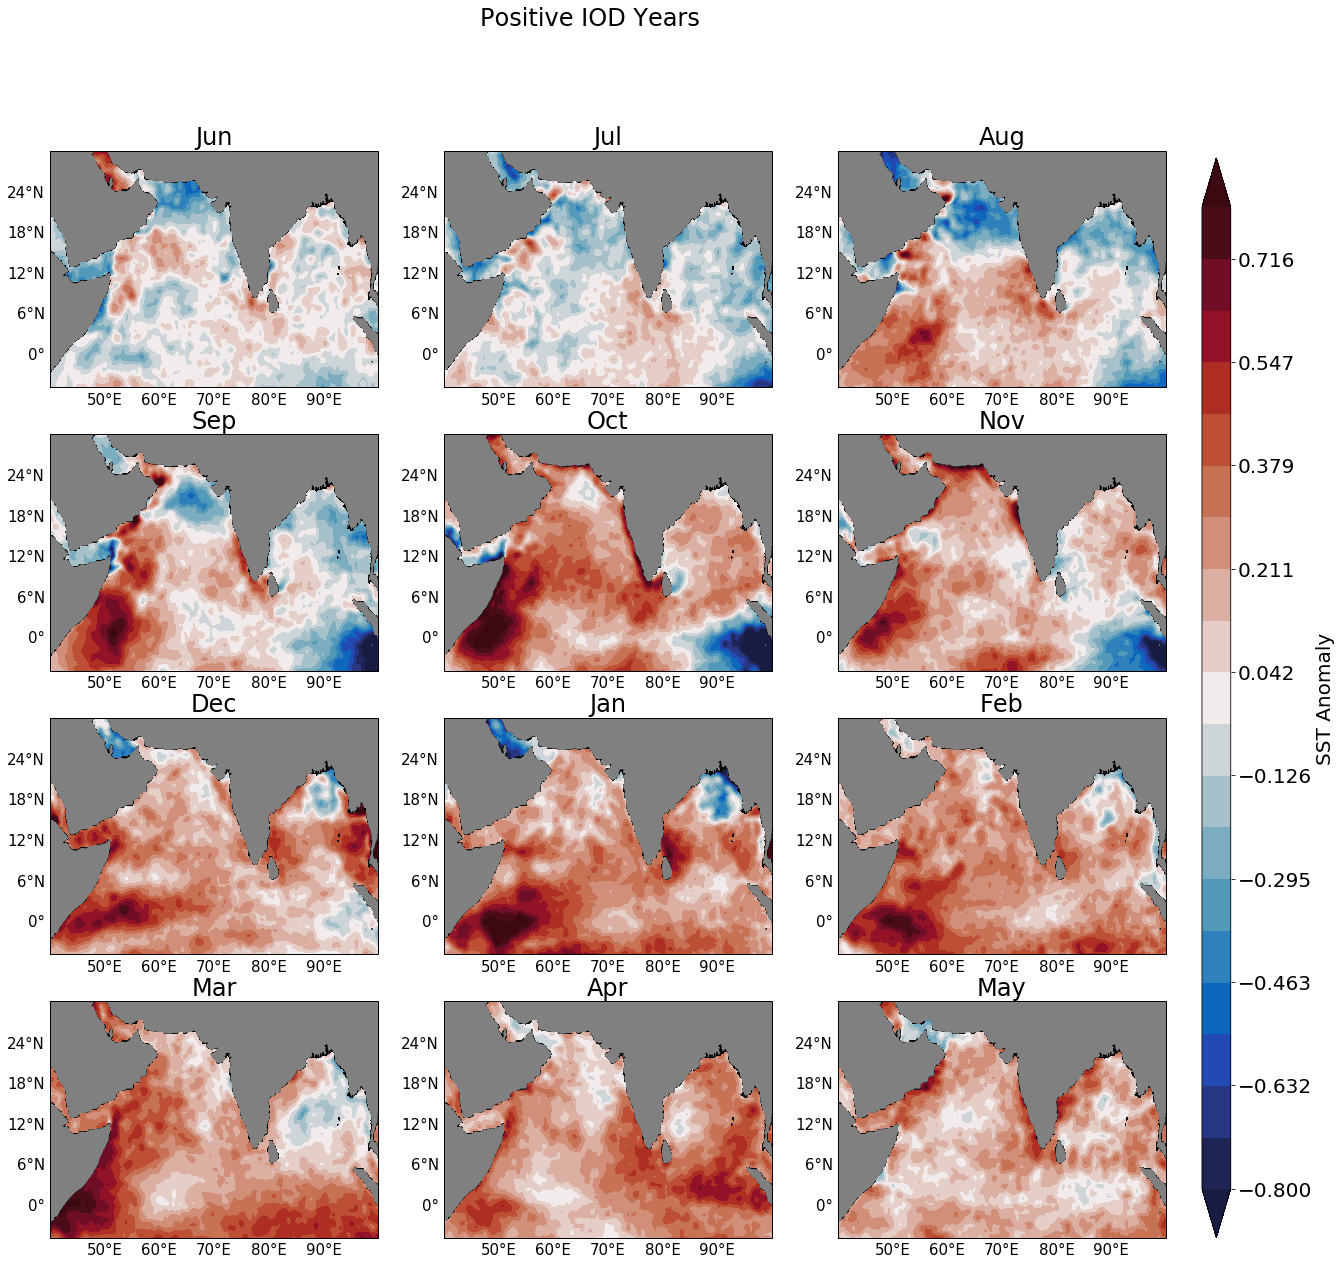

In [35]:
cmin = -0.8
cmax = 0.8

plot_annual_cycle(posIOD_mon_ssta_mon_anom,cmap = cmocean.cm.balance,cmin=cmin,cmax=cmax,clabel = 'SST Anomaly',
                  levels = np.linspace(cmin,cmax, 20),stitle ='Positive IOD Years')

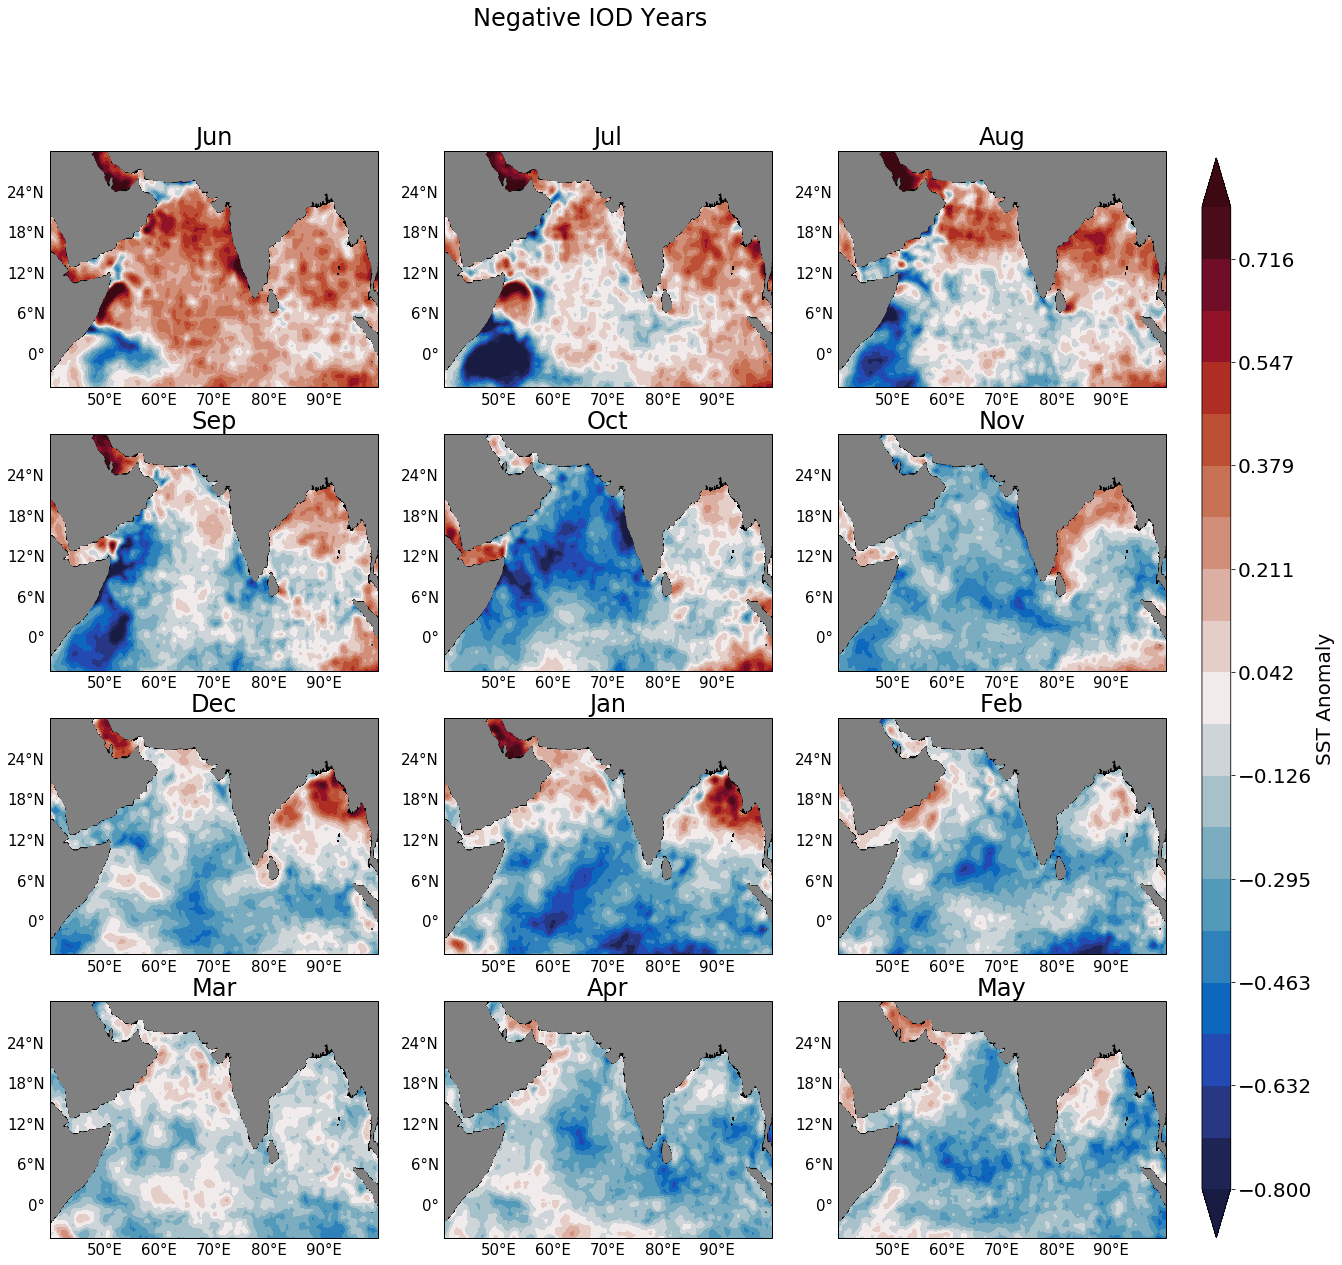

In [36]:
cmin = -0.8
cmax = 0.8

plot_annual_cycle(negIOD_mon_ssta_mon_anom,cmap = cmocean.cm.balance,cmin=cmin,cmax=cmax,clabel = 'SST Anomaly',
                  levels = np.linspace(cmin, cmax, 20),stitle ='Negative IOD Years')

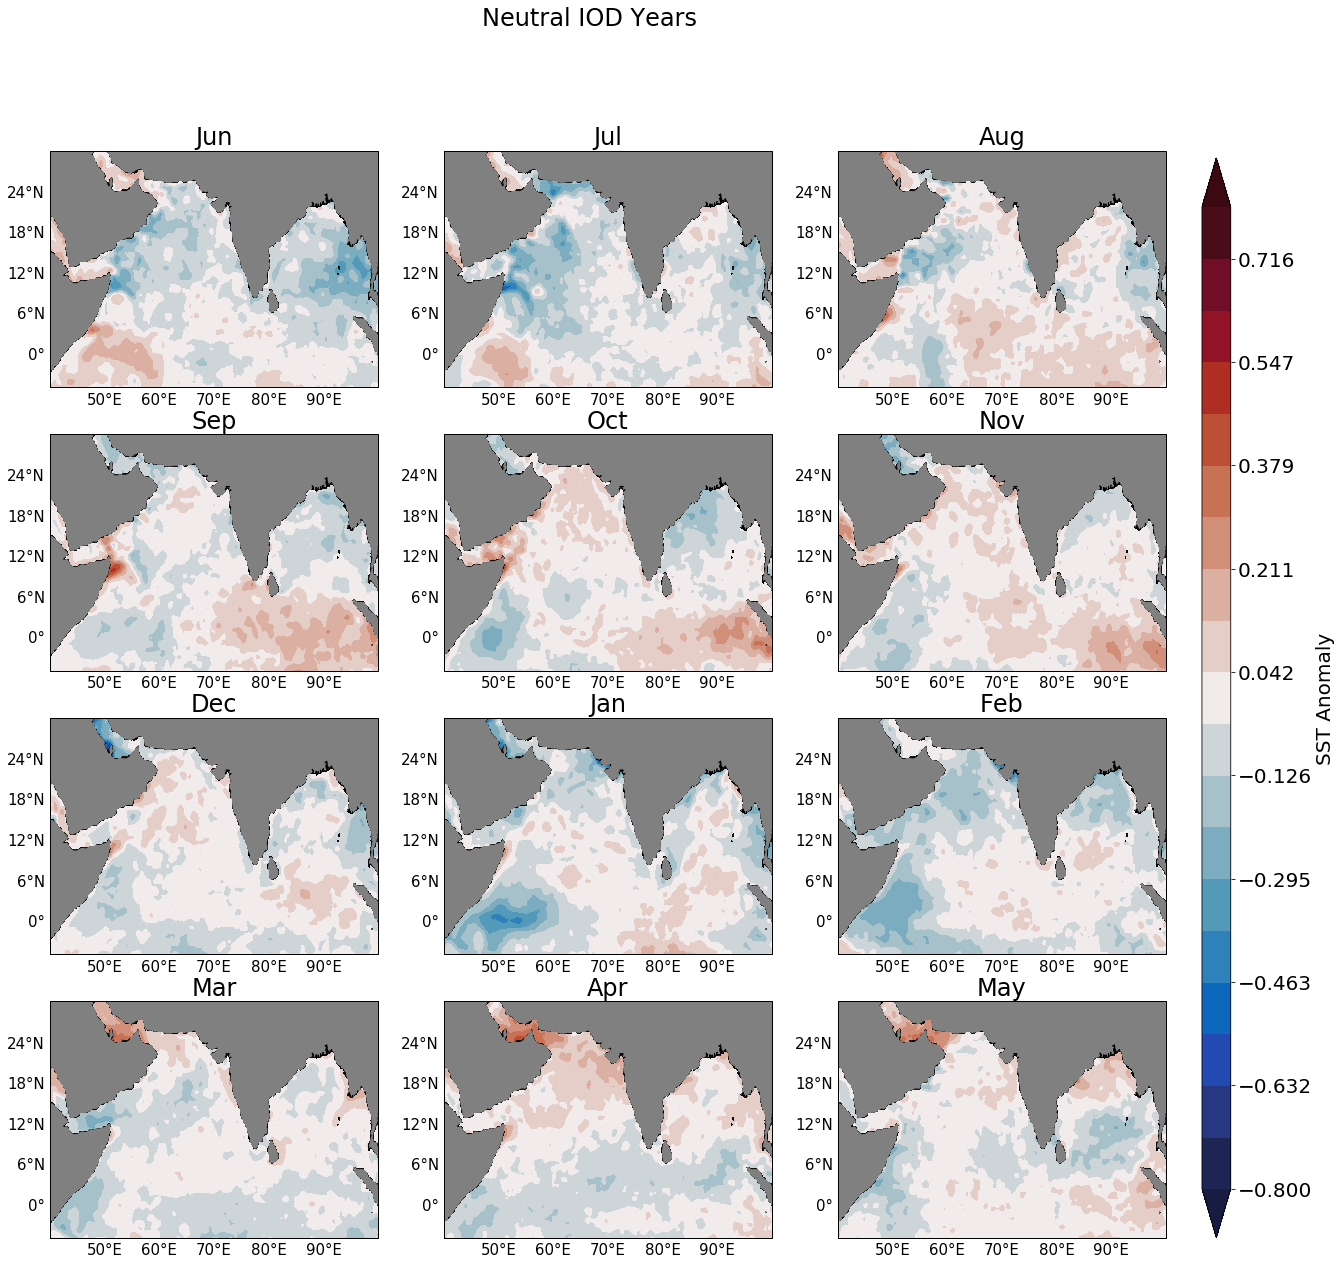

In [37]:
cmin = -0.8
cmax = 0.8
plot_annual_cycle(neuIOD_mon_ssta_mon_anom,cmap = cmocean.cm.balance,cmin=cmin,cmax=cmax,clabel = 'SST Anomaly',
                  levels = np.linspace(cmin, cmax, 20),stitle ='Neutral IOD Years')